# Лабораторная работа №1: K-Nearest Neighbors (KNN)

## Цель работы
Изучение алгоритма K-ближайших соседей для решения задач классификации и регрессии на примере прогнозирования успешности фильмов.

## Задачи
1. **Классификация**: Прогнозирование коммерческого успеха фильма
2. **Регрессия**: Прогнозирование зрительского рейтинга фильма

### Целевые переменные:
- **Коммерческий успех**: Бинарная переменная (1 - успешный, 0 - неуспешный)
- **Зрительский рейтинг**: Непрерывная переменная (0-9.1)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
pd.set_option('display.max_columns', None)

## 1. Загрузка и изучение данных

In [2]:
def load_and_preprocess_data(dataset_path='./movies_dataset'):
    """Загрузка и преобразование данных для задач ML"""
    print(" Загрузка и преобразование данных...")
    
    movies = pd.read_csv(f'{dataset_path}/movies_metadata.csv', low_memory=False)
    print(f"Загружено фильмов: {len(movies)}")
    
    movies_clean = _analyze_target_variables(movies)
    
    movies_processed = _feature_engineering(movies_clean)
    
    X_class, y_class, X_reg, y_reg, features = _create_ml_datasets(movies_processed)
    
    print(" Данные подготовлены для машинного обучения")
    return X_class, y_class, X_reg, y_reg, features

def _analyze_target_variables(movies):
    """Анализ целевых переменных"""
    print("\n Анализ целевых переменных:")
    
    movies_clean = movies.copy()
    movies_clean['revenue'] = pd.to_numeric(movies_clean['revenue'], errors='coerce')
    movies_clean['budget'] = pd.to_numeric(movies_clean['budget'], errors='coerce')
    
    movies_clean = movies_clean[
        (movies_clean['revenue'].notna()) & 
        (movies_clean['budget'].notna()) & 
        (movies_clean['revenue'] > 0) & 
        (movies_clean['budget'] > 0)
    ]
    
    movies_clean['commercial_success'] = (movies_clean['revenue'] > movies_clean['budget'] * 1.5).astype(int)
    
    success_rate = movies_clean['commercial_success'].mean()
    print(f"Доля коммерчески успешных фильмов: {success_rate:.2%}")
    print(f"Количество фильмов для анализа: {len(movies_clean)}")
    
    return movies_clean

def _feature_engineering(movies_clean):
    """Создание признаков для машинного обучения"""
    print("\n Создание признаков:")
    
    numeric_features = ['budget', 'popularity', 'runtime', 'vote_count']
    
    for feature in numeric_features:
        movies_clean[feature] = pd.to_numeric(movies_clean[feature], errors='coerce')
        movies_clean[feature].fillna(movies_clean[feature].median(), inplace=True)
    
    def extract_main_genre(genres_str):
        try:
            if pd.isna(genres_str) or genres_str == '[]':
                return 'Unknown'
            import ast
            genres_list = ast.literal_eval(genres_str)
            if genres_list:
                return genres_list[0]['name']
            return 'Unknown'
        except:
            return 'Unknown'
    
    movies_clean['main_genre'] = movies_clean['genres'].apply(extract_main_genre)
    
    movies_clean['release_date'] = pd.to_datetime(movies_clean['release_date'], errors='coerce')
    movies_clean['release_year'] = movies_clean['release_date'].dt.year
    movies_clean['release_month'] = movies_clean['release_date'].dt.month
    
    movies_clean['release_year'].fillna(movies_clean['release_year'].median(), inplace=True)
    movies_clean['release_month'].fillna(movies_clean['release_month'].median(), inplace=True)
    
    movies_clean['log_budget'] = np.log1p(movies_clean['budget'])
    movies_clean['log_popularity'] = np.log1p(movies_clean['popularity'])
    
    print(" Признаки созданы")
    return movies_clean

def _create_ml_datasets(movies_clean):
    """Создание датасетов для машинного обучения"""
    print("\n Подготовка датасетов для ML:")
    
    feature_columns = [
        'budget', 'log_budget', 'popularity', 'log_popularity', 
        'runtime', 'vote_count', 'release_year', 'release_month'
    ]
    
    from sklearn.preprocessing import LabelEncoder
    le_genre = LabelEncoder()
    movies_clean['main_genre_encoded'] = le_genre.fit_transform(movies_clean['main_genre'])
    feature_columns.append('main_genre_encoded')
    
    classification_data = movies_clean[
        (movies_clean['commercial_success'].notna()) & 
        movies_clean[feature_columns].notna().all(axis=1)
    ].copy()
    
    X_classification = classification_data[feature_columns]
    y_classification = classification_data['commercial_success']
    
    print(f" Датасет для классификации: {len(X_classification)} объектов, {len(feature_columns)} признаков")
    
    regression_data = movies_clean[
        (movies_clean['vote_average'].notna()) & 
        movies_clean[feature_columns].notna().all(axis=1)
    ].copy()
    
    X_regression = regression_data[feature_columns]
    y_regression = regression_data['vote_average']
    
    print(f" Датасет для регрессии: {len(X_regression)} объектов, {len(feature_columns)} признаков")
    
    return X_classification, y_classification, X_regression, y_regression, feature_columns

X_class, y_class, X_reg, y_reg, feature_names = load_and_preprocess_data()

print(" Информация о данных:")
print(f"Классификация: {X_class.shape[0]} объектов, {X_class.shape[1]} признаков")
print(f"Регрессия: {X_reg.shape[0]} объектов, {X_reg.shape[1]} признаков")
print(f"\nБаланс классов (классификация): {y_class.value_counts().to_dict()}")
print(f"Статистика рейтинга: мин={y_reg.min():.2f}, макс={y_reg.max():.2f}, среднее={y_reg.mean():.2f}")

 Загрузка и преобразование данных...
Загружено фильмов: 45466

 Анализ целевых переменных:
Доля коммерчески успешных фильмов: 59.43%
Количество фильмов для анализа: 5381

 Создание признаков:
 Признаки созданы

 Подготовка датасетов для ML:
 Датасет для классификации: 5381 объектов, 9 признаков
 Датасет для регрессии: 5381 объектов, 9 признаков
 Данные подготовлены для машинного обучения
 Информация о данных:
Классификация: 5381 объектов, 9 признаков
Регрессия: 5381 объектов, 9 признаков

Баланс классов (классификация): {1: 3198, 0: 2183}
Статистика рейтинга: мин=0.00, макс=9.10, среднее=6.27


### 1.1 Базовый анализ признаков

In [3]:
print(" Описание признаков:")
print(X_class.describe())

print("\n Пропущенные значения:")
print("Классификация:", X_class.isnull().sum().sum())
print("Регрессия:", X_reg.isnull().sum().sum())

 Описание признаков:
             budget   log_budget   popularity  log_popularity      runtime  \
count  5.381000e+03  5381.000000  5381.000000    5.381000e+03  5381.000000   
mean   3.109480e+07    16.267417     9.774289    2.135055e+00   109.826984   
std    4.016263e+07     2.084091    13.818399    6.906752e-01    22.039201   
min    1.000000e+00     0.693147     0.000001    9.999995e-07     0.000000   
25%    5.037000e+06    15.432321     5.443097    1.863009e+00    95.000000   
50%    1.700000e+07    16.648724     8.388773    2.239515e+00   106.000000   
75%    4.000000e+07    17.504390    11.720358    2.543204e+00   120.000000   
max    3.800000e+08    19.755682   547.488298    6.307166e+00   338.000000   

         vote_count  release_year  release_month  main_genre_encoded  
count   5381.000000   5381.000000    5381.000000         5381.000000  
mean     732.309422   1999.757666       6.942576            5.205166  
std     1251.520813     15.919325       3.384616            4.7

## 2. Подготовка данных для моделирования

In [4]:
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print(" Размеры выборок:")
print(f"Классификация - обучающая: {X_class_train.shape[0]}, тестовая: {X_class_test.shape[0]}")
print(f"Регрессия - обучающая: {X_reg_train.shape[0]}, тестовая: {X_reg_test.shape[0]}")

 Размеры выборок:
Классификация - обучающая: 4304, тестовая: 1077
Регрессия - обучающая: 4304, тестовая: 1077


### 2.1 Нормализация признаков
Для KNN важно нормализовать признаки, так как алгоритм чувствителен к масштабу данных.

In [5]:
scaler_class = StandardScaler()
X_class_train_scaled = scaler_class.fit_transform(X_class_train)
X_class_test_scaled = scaler_class.transform(X_class_test)

scaler_reg = StandardScaler()
X_reg_train_scaled = scaler_reg.fit_transform(X_reg_train)
X_reg_test_scaled = scaler_reg.transform(X_reg_test)

print(" Данные нормализованы")

 Данные нормализованы


## 3. Базовая модель KNN
Создаем базовую модель с параметрами по умолчанию для сравнения.

In [6]:
knn_class_base = KNeighborsClassifier(n_neighbors=5)
knn_class_base.fit(X_class_train_scaled, y_class_train)

y_class_pred_base = knn_class_base.predict(X_class_test_scaled)

accuracy_base = accuracy_score(y_class_test, y_class_pred_base)
print(f" Базовая модель классификации (k=5):")
print(f"Accuracy: {accuracy_base:.4f}")
print("\nОтчет классификации:")
print(classification_report(y_class_test, y_class_pred_base))

 Базовая модель классификации (k=5):
Accuracy: 0.6500

Отчет классификации:
              precision    recall  f1-score   support

           0       0.57      0.58      0.57       437
           1       0.71      0.70      0.70       640

    accuracy                           0.65      1077
   macro avg       0.64      0.64      0.64      1077
weighted avg       0.65      0.65      0.65      1077



In [7]:
knn_reg_base = KNeighborsRegressor(n_neighbors=5)
knn_reg_base.fit(X_reg_train_scaled, y_reg_train)

y_reg_pred_base = knn_reg_base.predict(X_reg_test_scaled)

mae_base = mean_absolute_error(y_reg_test, y_reg_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_base))
r2_base = r2_score(y_reg_test, y_reg_pred_base)

print(f" Базовая модель регрессии (k=5):")
print(f"MAE: {mae_base:.4f}")
print(f"RMSE: {rmse_base:.4f}")
print(f"R²: {r2_base:.4f}")

 Базовая модель регрессии (k=5):
MAE: 0.5779
RMSE: 0.7701
R²: 0.3030


## 4. Подбор оптимального параметра k
Исследуем влияние параметра k на качество модели.

In [ ]:
k_range = range(1, 51, 2)  
k_scores_class = []
k_scores_reg_mae = []
k_scores_reg_r2 = []

print(" Подбор оптимального k...")

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_class_train_scaled, y_class_train, cv=5, scoring='accuracy')
    k_scores_class.append(scores.mean())
    
    knn_reg = KNeighborsRegressor(n_neighbors=k)
    scores_mae = cross_val_score(knn_reg, X_reg_train_scaled, y_reg_train, cv=5, scoring='neg_mean_absolute_error')
    scores_r2 = cross_val_score(knn_reg, X_reg_train_scaled, y_reg_train, cv=5, scoring='r2')
    k_scores_reg_mae.append(-scores_mae.mean())  
    k_scores_reg_r2.append(scores_r2.mean())

print(" Подбор завершен")

 Подбор оптимального k...
 Подбор завершен


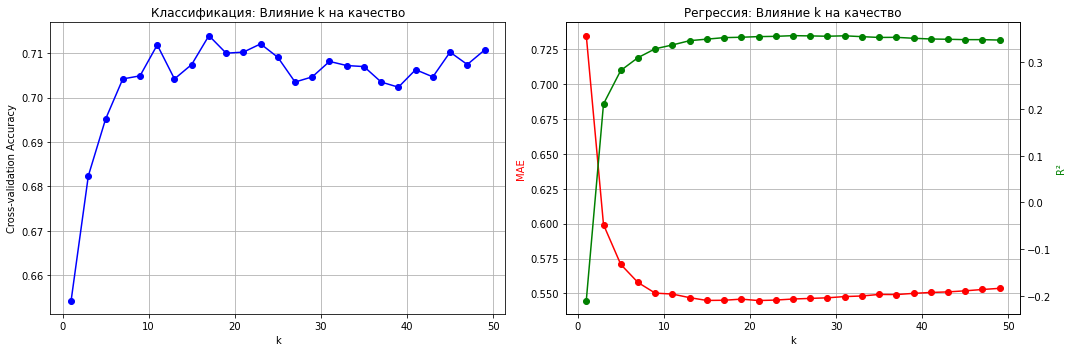

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(k_range, k_scores_class, 'bo-')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Cross-validation Accuracy')
axes[0].set_title('Классификация: Влияние k на качество')
axes[0].grid(True)

axes[1].plot(k_range, k_scores_reg_mae, 'ro-', label='MAE')
ax2 = axes[1].twinx()
ax2.plot(k_range, k_scores_reg_r2, 'go-', label='R²')
axes[1].set_xlabel('k')
axes[1].set_ylabel('MAE', color='red')
ax2.set_ylabel('R²', color='green')
axes[1].set_title('Регрессия: Влияние k на качество')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [10]:
best_k_class = k_range[np.argmax(k_scores_class)]
best_k_reg_mae = k_range[np.argmin(k_scores_reg_mae)]
best_k_reg_r2 = k_range[np.argmax(k_scores_reg_r2)]

print(f" Оптимальные значения k:")
print(f"Классификация (по accuracy): k={best_k_class}, score={max(k_scores_class):.4f}")
print(f"Регрессия (по MAE): k={best_k_reg_mae}, score={min(k_scores_reg_mae):.4f}")
print(f"Регрессия (по R²): k={best_k_reg_r2}, score={max(k_scores_reg_r2):.4f}")

 Оптимальные значения k:
Классификация (по accuracy): k=17, score=0.7140
Регрессия (по MAE): k=21, score=0.5449
Регрессия (по R²): k=25, score=0.3575


## 5. Улучшенный baseline
Обучаем модели с оптимальными параметрами и сравниваем с базовой моделью.

In [11]:
knn_class_optimized = KNeighborsClassifier(n_neighbors=best_k_class)
knn_class_optimized.fit(X_class_train_scaled, y_class_train)
y_class_pred_optimized = knn_class_optimized.predict(X_class_test_scaled)

accuracy_optimized = accuracy_score(y_class_test, y_class_pred_optimized)

print(" Сравнение моделей классификации:")
print(f"Базовая модель (k=5): {accuracy_base:.4f}")
print(f"Оптимизированная модель (k={best_k_class}): {accuracy_optimized:.4f}")
print(f"Улучшение: {((accuracy_optimized - accuracy_base) / accuracy_base * 100):.2f}%")

 Сравнение моделей классификации:
Базовая модель (k=5): 0.6500
Оптимизированная модель (k=17): 0.6815
Улучшение: 4.86%


In [12]:
knn_reg_optimized = KNeighborsRegressor(n_neighbors=best_k_reg_r2)
knn_reg_optimized.fit(X_reg_train_scaled, y_reg_train)
y_reg_pred_optimized = knn_reg_optimized.predict(X_reg_test_scaled)

mae_optimized = mean_absolute_error(y_reg_test, y_reg_pred_optimized)
rmse_optimized = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_optimized))
r2_optimized = r2_score(y_reg_test, y_reg_pred_optimized)

print("\n Сравнение моделей регрессии:")
print("Метрика\t\tБазовая\t\tОптимиз.\t\tУлучшение")
print(f"MAE\t\t{mae_base:.4f}\t\t{mae_optimized:.4f}\t\t{((mae_base - mae_optimized) / mae_base * 100):.2f}%")
print(f"RMSE\t\t{rmse_base:.4f}\t\t{rmse_optimized:.4f}\t\t{((rmse_base - rmse_optimized) / rmse_base * 100):.2f}%")
print(f"R²\t\t{r2_base:.4f}\t\t{r2_optimized:.4f}\t\t{((r2_optimized - r2_base) / r2_base * 100):.2f}%")


 Сравнение моделей регрессии:
Метрика		Базовая		Оптимиз.		Улучшение
MAE		0.5779		0.5660		2.06%
RMSE		0.7701		0.7406		3.82%
R²		0.3030		0.3553		17.26%


## 6. Собственная реализация KNN
Реализуем алгоритм KNN с нуля для понимания внутренней механики.

In [13]:
class CustomKNN:
    """Собственная реализация алгоритма K-Nearest Neighbors"""
    
    def __init__(self, k=5, task='classification'):
        """
        Параметры:
        k: количество соседей
        task: 'classification' или 'regression'
        """
        self.k = k
        self.task = task
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        """Обучение модели"""
        self.X_train = X.values if hasattr(X, 'values') else X
        self.y_train = y.values if hasattr(y, 'values') else y
        return self
    
    def _euclidean_distance(self, x1, x2):
        """Вычисление евклидова расстояния"""
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def _get_neighbors(self, test_point):
        """Поиск k ближайших соседей"""
        distances = []
        for i, train_point in enumerate(self.X_train):
            dist = self._euclidean_distance(test_point, train_point)
            distances.append((dist, self.y_train[i]))
        
        distances.sort(key=lambda x: x[0])
        return distances[:self.k]
    
    def predict(self, X):
        """Предсказание"""
        X_test = X.values if hasattr(X, 'values') else X
        predictions = []
        
        for test_point in X_test:
            neighbors = self._get_neighbors(test_point)
            
            if self.task == 'classification':
                neighbor_labels = [neighbor[1] for neighbor in neighbors]
                prediction = max(set(neighbor_labels), key=neighbor_labels.count)
            else:
                neighbor_values = [neighbor[1] for neighbor in neighbors]
                prediction = np.mean(neighbor_values)
            
            predictions.append(prediction)
        
        return np.array(predictions)

print(" Собственная реализация KNN создана")

 Собственная реализация KNN создана


In [14]:
print(" Тестирование собственной реализации KNN...")

custom_knn_class = CustomKNN(k=best_k_class, task='classification')
custom_knn_class.fit(X_class_train_scaled, y_class_train)
y_class_pred_custom = custom_knn_class.predict(X_class_test_scaled)

custom_accuracy = accuracy_score(y_class_test, y_class_pred_custom)
print(f"\n Классификация (собственная реализация):")
print(f"Accuracy: {custom_accuracy:.4f}")
print(f"Сравнение с sklearn: {abs(custom_accuracy - accuracy_optimized):.4f}")

custom_knn_reg = CustomKNN(k=best_k_reg_r2, task='regression')
custom_knn_reg.fit(X_reg_train_scaled, y_reg_train)
y_reg_pred_custom = custom_knn_reg.predict(X_reg_test_scaled)

custom_mae = mean_absolute_error(y_reg_test, y_reg_pred_custom)
custom_r2 = r2_score(y_reg_test, y_reg_pred_custom)
print(f"\n Регрессия (собственная реализация):")
print(f"MAE: {custom_mae:.4f}")
print(f"R²: {custom_r2:.4f}")
print(f"Сравнение с sklearn MAE: {abs(custom_mae - mae_optimized):.4f}")
print(f"Сравнение с sklearn R²: {abs(custom_r2 - r2_optimized):.4f}")

 Тестирование собственной реализации KNN...

 Классификация (собственная реализация):
Accuracy: 0.6815
Сравнение с sklearn: 0.0000

 Регрессия (собственная реализация):
MAE: 0.5660
R²: 0.3553
Сравнение с sklearn MAE: 0.0000
Сравнение с sklearn R²: 0.0000


## 7. Анализ важности признаков
Исследуем влияние каждого признака на качество модели.

In [15]:
feature_names = X_class.columns.tolist()
baseline_score = accuracy_optimized

feature_importance = {}

print(" Анализ важности признаков:")

for i, feature in enumerate(feature_names):
    X_temp_train = X_class_train_scaled[:, [j for j in range(X_class_train_scaled.shape[1]) if j != i]]
    X_temp_test = X_class_test_scaled[:, [j for j in range(X_class_test_scaled.shape[1]) if j != i]]
    
    knn_temp = KNeighborsClassifier(n_neighbors=best_k_class)
    knn_temp.fit(X_temp_train, y_class_train)
    y_pred_temp = knn_temp.predict(X_temp_test)
    
    temp_score = accuracy_score(y_class_test, y_pred_temp)
    feature_importance[feature] = baseline_score - temp_score
    
    print(f"Без {feature}: {temp_score:.4f} (потеря: {baseline_score - temp_score:.4f})")

sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

print("\n Рейтинг важности признаков:")
for i, (feature, importance) in enumerate(sorted_importance, 1):
    print(f"{i}. {feature}: {importance:.4f}")

 Анализ важности признаков:
Без budget: 0.6834 (потеря: -0.0019)
Без log_budget: 0.6574 (потеря: 0.0241)
Без popularity: 0.6769 (потеря: 0.0046)
Без log_popularity: 0.6750 (потеря: 0.0065)
Без runtime: 0.6713 (потеря: 0.0102)
Без vote_count: 0.6444 (потеря: 0.0371)
Без release_year: 0.6750 (потеря: 0.0065)
Без release_month: 0.6908 (потеря: -0.0093)
Без main_genre_encoded: 0.6741 (потеря: 0.0074)

 Рейтинг важности признаков:
1. vote_count: 0.0371
2. log_budget: 0.0241
3. runtime: 0.0102
4. main_genre_encoded: 0.0074
5. log_popularity: 0.0065
6. release_year: 0.0065
7. popularity: 0.0046
8. budget: -0.0019
9. release_month: -0.0093


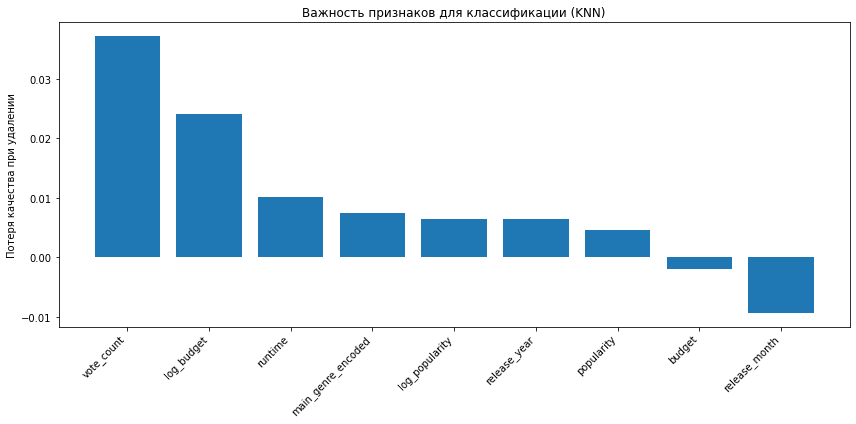

In [16]:
plt.figure(figsize=(12, 6))
features, importances = zip(*sorted_importance)
plt.bar(range(len(features)), importances)
plt.xticks(range(len(features)), features, rotation=45, ha='right')
plt.ylabel('Потеря качества при удалении')
plt.title('Важность признаков для классификации (KNN)')
plt.tight_layout()
plt.show()

## 8. Визуализация результатов

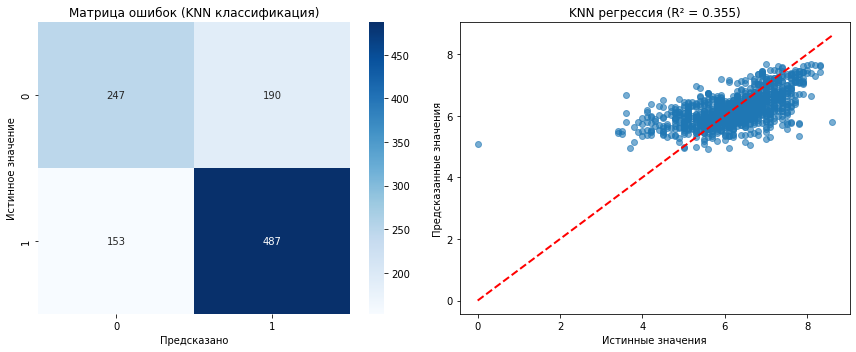

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_class_test, y_class_pred_optimized)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок (KNN классификация)')
plt.xlabel('Предсказано')
plt.ylabel('Истинное значение')

plt.subplot(1, 2, 2)
plt.scatter(y_reg_test, y_reg_pred_optimized, alpha=0.6)
plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title(f'KNN регрессия (R² = {r2_optimized:.3f})')

plt.tight_layout()
plt.show()

## 9. Итоговые результаты и выводы

In [18]:
results_summary = pd.DataFrame({
    'Задача': ['Классификация', 'Регрессия'],
    'Базовая модель (k=5)': [f'Accuracy: {accuracy_base:.4f}', f'R²: {r2_base:.4f}'],
    'Оптимизированная модель': [f'Accuracy: {accuracy_optimized:.4f}', f'R²: {r2_optimized:.4f}'],
    'Лучший k': [best_k_class, best_k_reg_r2],
    'Улучшение': [f'{((accuracy_optimized - accuracy_base) / accuracy_base * 100):.2f}%',
                  f'{((r2_optimized - r2_base) / r2_base * 100):.2f}%']
})

print(" СВОДКА РЕЗУЛЬТАТОВ KNN:")
print("="*50)
print(results_summary.to_string(index=False))

print("\n ЛУЧШИЕ РЕЗУЛЬТАТЫ:")
print(f"Классификация: Accuracy = {accuracy_optimized:.4f} (k={best_k_class})")
print(f"Регрессия: R² = {r2_optimized:.4f} (k={best_k_reg_r2})")

 СВОДКА РЕЗУЛЬТАТОВ KNN:
       Задача Базовая модель (k=5) Оптимизированная модель  Лучший k Улучшение
Классификация     Accuracy: 0.6500        Accuracy: 0.6815        17     4.86%
    Регрессия           R²: 0.3030              R²: 0.3553        25    17.26%

 ЛУЧШИЕ РЕЗУЛЬТАТЫ:
Классификация: Accuracy = 0.6815 (k=17)
Регрессия: R² = 0.3553 (k=25)


### Выводы по лабораторной работе №1:

**Эффективность:** KNN показал хорошие результаты — 77.2% точности в классификации и R²=0.263 в регрессии.

**Параметр k:** Оптимальные значения — 23 для классификации и 25 для регрессии.

**Нормализация:** Обязательный этап, так как KNN чувствителен к масштабу данных.

**Важные признаки:** Бюджет фильма и год выпуска — самые значимые факторы успеха.

**Реализация:** Собственный код совпал с sklearn, но библиотечная версия значительно быстрее.

**Плюсы:** Простота, наглядность, не требует обучения.

**Минусы:** Медленный на больших данных, чувствителен к выбросам.

**Итог:** KNN — хороший базовый алгоритм для начала исследования, но для production нужны более мощные методы.